<font size=4> Добрый день, Евгений! Меня зовут Алан Созанов, будем обмениваться с тобой опытом для успешного прохождения задания! Если не против, предлагаю общаться на ты (иначе дай знать, и перейдем на «вы»). Свои рекомендации буду оформлять в виде комментариев в Markdown ячейках:<br><strong>
    <li> <font color='red'> «красный цвет» </font> – важно исправить или внести пояснения
    <li> <font color='orange'> «желтый цвет» </font>  – учесть, но можно не исправлять 
    <li> <font color='green'> «зеленый цвет» </font> – все отлично, плюс альтернативные пути решения задачи
        </strong>
<br> Прошу при внесении правок мои комментарии не удалять, а свои писать в соседних ячейках и выделять удобным цветом. Так коммуникация будет проходить эффективнее 👍.<br>
</font>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки:
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак:
* Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import lightgbm as lgb

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
data = pd.read_csv('/datasets/autos.csv')
data.info()
display(data.head())
display(data.describe())
print('Дубликатов:', data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Дубликатов: 4


In [3]:
print('Уникальные значение поля VehicleType:', data['VehicleType'].unique())
print('Уникальные значение поля Gearbox:', data['Gearbox'].unique())
print('Уникальные значение поля Model:', data['Model'].unique())
print('Уникальные значение поля FuelType:', data['FuelType'].unique())
print('Уникальные значение поля Brand:', data['Brand'].unique())
print('Уникальные значение поля NotRepaired:', data['NotRepaired'].unique())

Уникальные значение поля VehicleType: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Уникальные значение поля Gearbox: ['manual' 'auto' nan]
Уникальные значение поля Model: ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er'

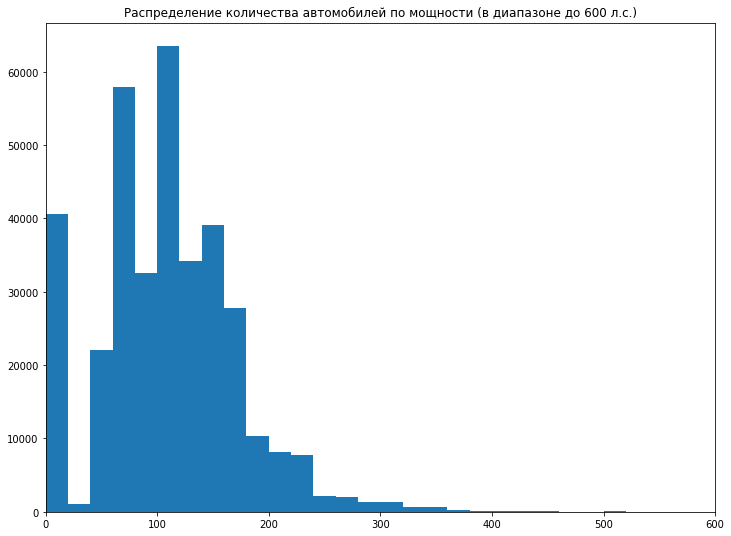

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
431,2016-03-20 20:45:27,3950,small,2004,auto,5,NaN,70000,5,gasoline,sonstige_autos,no,2016-03-20 00:00:00,0,90562,2016-04-03 04:17:08
3349,2016-03-29 17:37:58,1990,small,2004,NaN,7,polo,150000,5,gasoline,volkswagen,no,2016-03-29 00:00:00,0,37124,2016-04-02 05:16:40
9561,2016-04-04 07:58:34,9000,sedan,2009,manual,2,a4,5000,12,gasoline,audi,NaN,2016-04-04 00:00:00,0,12045,2016-04-06 10:17:01
12747,2016-03-24 16:38:53,2850,small,2005,auto,5,NaN,40000,8,gasoline,sonstige_autos,no,2016-03-24 00:00:00,0,56825,2016-04-07 08:44:59
16228,2016-04-02 22:47:03,2500,small,2006,auto,5,NaN,40000,1,gasoline,sonstige_autos,yes,2016-04-02 00:00:00,0,78532,2016-04-04 21:17:01
16237,2016-03-08 17:56:37,4500,other,2006,auto,5,NaN,40000,7,electric,sonstige_autos,no,2016-03-08 00:00:00,0,77855,2016-04-07 08:46:28
16523,2016-03-26 10:48:50,4600,other,2012,manual,4,NaN,20000,9,gasoline,sonstige_autos,no,2016-03-26 00:00:00,0,40822,2016-03-26 10:48:50
20229,2016-03-17 22:48:49,4999,sedan,2003,manual,1,e_klasse,150000,12,gasoline,mercedes_benz,NaN,2016-03-17 00:00:00,0,66571,2016-03-17 23:44:50
20493,2016-03-28 14:56:39,5200,small,1998,auto,5,NaN,40000,9,gasoline,sonstige_autos,NaN,2016-03-28 00:00:00,0,84085,2016-04-04 18:15:43
21482,2016-03-11 08:51:45,2900,small,2001,auto,5,NaN,20000,4,gasoline,sonstige_autos,no,2016-03-11 00:00:00,0,53501,2016-04-06 06:46:24


In [4]:
plt.figure(figsize=[12,9])
plt.xlim([0, 600])
#plt.ylim([0, 900])

plt.hist(data['Power'], bins=1000)
#plt.hist(gold_recovery_train['final.output.recovery'], bins=100, label='Финальная', alpha=0.7)

#plt.xlabel("Эффективность обогащения")
#plt.ylabel("Количество результатов производства")
plt.title("Распределение количества автомобилей по мощности (в диапазоне до 600 л.с.)")
#plt.legend(loc='upper left', fontsize='x-large')
#plt.legend(['Поcле флотации', 'Финальная'])
plt.show()
display(data.query('Power>0 and Power<10').head(10))

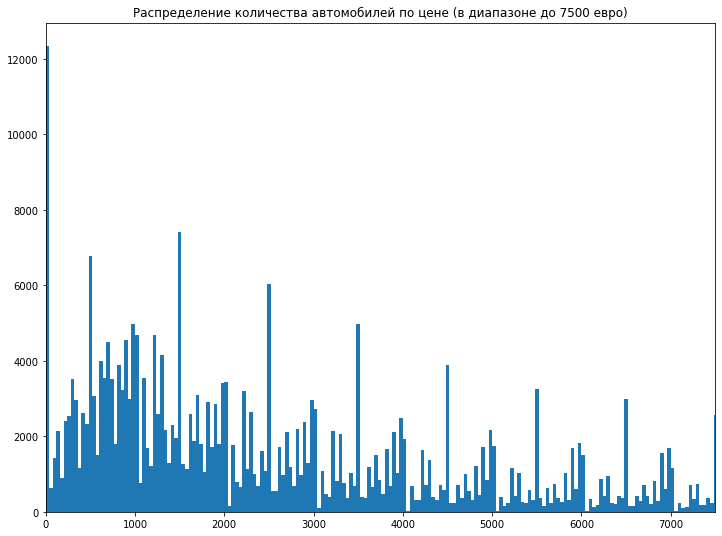

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29 00:00:00,0,53721,2016-04-06 01:44:38
89,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-28 00:00:00,0,40589,2016-04-06 12:15:54
268,2016-03-12 07:26:49,1,sedan,1990,manual,90,80,70000,6,petrol,audi,no,2016-03-11 00:00:00,0,55122,2016-03-26 23:15:49
408,2016-03-29 18:51:58,1,NaN,2000,NaN,75,golf,90000,3,petrol,volkswagen,NaN,2016-03-29 00:00:00,0,78588,2016-04-06 04:45:50
901,2016-03-06 00:25:25,1,NaN,1990,manual,0,other,150000,0,NaN,porsche,NaN,2016-03-05 00:00:00,0,65843,2016-04-06 20:19:08
967,2016-03-23 08:21:11,1,wagon,1998,manual,136,omega,150000,0,petrol,opel,no,2016-03-22 00:00:00,0,57614,2016-03-27 08:45:52
1025,2016-03-15 18:57:12,3,convertible,1998,manual,110,mx_reihe,150000,11,NaN,mazda,yes,2016-03-15 00:00:00,0,89312,2016-04-06 21:16:58
1247,2016-03-24 15:57:20,1,sedan,1983,manual,0,NaN,150000,6,petrol,mercedes_benz,no,2016-03-24 00:00:00,0,53173,2016-04-07 08:45:25
1340,2016-03-16 21:47:22,1,NaN,2016,manual,0,golf,150000,0,gasoline,volkswagen,yes,2016-03-16 00:00:00,0,49401,2016-04-07 09:45:43
1542,2016-03-25 14:39:33,1,NaN,2000,NaN,0,astra,150000,0,NaN,opel,NaN,2016-03-25 00:00:00,0,24601,2016-03-27 00:44:31


In [5]:
plt.figure(figsize=[12,9])
plt.hist(data['Price'], bins=500)
plt.xlim([0, 7500])
plt.title("Распределение количества автомобилей по цене (в диапазоне до 7500 евро)")
plt.show()
display(data.query('Price>0 and Price<10').head(10))

### Выводы: 
1. В столбцах 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired' есть пропуски. Такие строки я предагаю удалить, т.к. их справление может привести к искажениям исходных данных.
2. В столбцах 'RegistrationYear', 'RegistrationMonth', 'Power',  есть некорректные значения. Такие строки я предагаю удалить, т.к. их справление может привести к искажениям исходных данных.
3. Столбец 'NumberOfPictures' содержит только нули.
4. Столбцы 'PostalCode', 'LastSeen', 'NumberOfPictures', 'RegistrationMonth', 'DateCreated', 'DateCrawled' обычно не влияют на цену автомобиля и могут быть исключены.
5. Кроме явно ошибочных нулевых значений цены и мощности есть и большое количество маргинальных значений, которые возможно  будут портить картину, но не совсем понятно, где их отсекать. Сделал отсечку на мощности 40 л.с. и цене 100 евро.

In [6]:
# Удаляем ненужные столбцы
data = data.drop(['PostalCode', 'LastSeen', 'NumberOfPictures', 'RegistrationMonth', 'DateCreated', 'DateCrawled'], axis=1)
# Заполняем пропуски новым значением
data['NotRepaired'] = data['NotRepaired'].fillna('unknown')
# Удаляем оставшиеся пропуски
data = data.dropna()
# Удаляем некорретные значения
data = data.query('RegistrationYear>1900 and RegistrationYear<2023 and Power>40 and Price>100')
# Удаляем дубликаты чтобы немного сбалансировать классы
data = data.drop_duplicates().reset_index(drop=True)
data.info()
display(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224137 entries, 0 to 224136
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             224137 non-null  int64 
 1   VehicleType       224137 non-null  object
 2   RegistrationYear  224137 non-null  int64 
 3   Gearbox           224137 non-null  object
 4   Power             224137 non-null  int64 
 5   Model             224137 non-null  object
 6   Kilometer         224137 non-null  int64 
 7   FuelType          224137 non-null  object
 8   Brand             224137 non-null  object
 9   NotRepaired       224137 non-null  object
dtypes: int64(4), object(6)
memory usage: 17.1+ MB


,Price,RegistrationYear,Power,Kilometer
count,224137.000000,224137.000000,224137.000000,224137.000000
mean,5223.861130,2002.957999,126.858805,126804.922882
std,4722.481769,6.113078,181.188529,37307.447758
min,101.000000,1910.000000,41.000000,5000.000000
25%,1500.000000,1999.000000,84.000000,125000.000000
50%,3550.000000,2003.000000,116.000000,150000.000000
75%,7500.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2018.000000,20000.000000,150000.000000


## Обучение моделей

Нам необходимо спрогнозировать цену, а это - задача регрессии.

In [7]:
# Наборы без OHE-кодирования
features_train, features_valid, target_train, target_valid = train_test_split(data.drop('Price', axis=1), data.Price, test_size=0.25, random_state=12345)
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
print('Размерность обучающей выборки без кодирования:', features_train.shape)
print('Размерность валидационной выборки без кодирования:', features_valid.shape)
print('')
# Наборы с OHE-кодированием
data_ohe = pd.get_dummies(data, columns=cat_features, drop_first=True)
features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(data_ohe.drop('Price', axis=1), data_ohe.Price, test_size=0.3, random_state=12345)
features_test_ohe, features_valid_ohe, target_test_ohe, target_valid_ohe = train_test_split(features_valid_ohe, target_valid_ohe, test_size=0.5, random_state=12345)
print('Размерность обучающей выборки с OHE-кодированием:', features_train_ohe.shape)
print('Размерность валидационной выборки с OHE-кодированием:', features_valid_ohe.shape)
print('Размерность тестовой выборки с OHE-кодированием:', features_test_ohe.shape)
# Удалим ненужные данные
del data

Размерность обучающей выборки без кодирования: (168102, 9)
Размерность валидационной выборки без кодирования: (56035, 9)

Размерность обучающей выборки с OHE-кодированием: (156895, 305)
Размерность валидационной выборки с OHE-кодированием: (33621, 305)
Размерность тестовой выборки с OHE-кодированием: (33621, 305)


In [8]:
%%time

model = CatBoostRegressor(loss_function='RMSE', learning_rate=0.15, bootstrap_type='MVS', depth=16, grow_policy='Lossguide', iterations=250, random_seed=12345)
model.fit(features_train, target_train, cat_features=cat_features, verbose=10, plot=False)

0:	learn: 4224.6673695	total: 205ms	remaining: 51s
10:	learn: 2199.1947600	total: 1.51s	remaining: 32.7s
20:	learn: 1852.0485108	total: 2.84s	remaining: 31s
30:	learn: 1760.1438777	total: 4.51s	remaining: 31.8s
40:	learn: 1713.2468933	total: 6.09s	remaining: 31s
50:	learn: 1684.9587726	total: 7.62s	remaining: 29.7s
60:	learn: 1665.5181125	total: 8.99s	remaining: 27.9s
70:	learn: 1649.5915290	total: 10.3s	remaining: 26.1s
80:	learn: 1636.4814175	total: 12s	remaining: 25.1s
90:	learn: 1624.1959327	total: 13.5s	remaining: 23.5s
100:	learn: 1613.7348275	total: 14.7s	remaining: 21.7s
110:	learn: 1605.6605894	total: 15.9s	remaining: 20s
120:	learn: 1597.5225998	total: 17.1s	remaining: 18.2s
130:	learn: 1589.0367525	total: 18.2s	remaining: 16.5s
140:	learn: 1581.7285201	total: 19.3s	remaining: 15s
150:	learn: 1576.1974317	total: 20.5s	remaining: 13.5s
160:	learn: 1571.1930226	total: 21.5s	remaining: 11.9s
170:	learn: 1567.1254328	total: 22.7s	remaining: 10.5s
180:	learn: 1563.5532187	total: 2

Теперь поэкспериментируем с другими моделями:
* Случайного леса в регрессии
* Гребневой регрессии
* LightGBM

In [9]:
%%time

model_rf = RandomForestRegressor(random_state=12345, n_estimators=100, max_depth=10)
model_rf.fit(features_train_ohe, target_train_ohe)

CPU times: user 2min 56s, sys: 581 ms, total: 2min 57s
Wall time: 2min 57s


RandomForestRegressor(max_depth=10, random_state=12345)

In [10]:
%%time

model_rgn = Ridge(random_state=12345, solver='auto', max_iter=15000, fit_intercept=True, normalize=False)
model_rgn.fit(features_train_ohe, target_train_ohe)

CPU times: user 1.07 s, sys: 783 ms, total: 1.85 s
Wall time: 1.79 s


Ridge(max_iter=15000, random_state=12345)

In [11]:
%%time

print("Версия LightGBM: ", lgb.__version__)

model_lgb = lgb.LGBMRegressor(objective="regression_l2", n_estimators=150)
model_lgb.fit(features_train_ohe, target_train_ohe, eval_set=[(features_valid_ohe, target_valid_ohe),], eval_metric="rmse")


Версия LightGBM:  3.3.1
[1]	valid_0's rmse: 4382.82	valid_0's l2: 1.92091e+07
[2]	valid_0's rmse: 4078.88	valid_0's l2: 1.66372e+07
[3]	valid_0's rmse: 3808.58	valid_0's l2: 1.45053e+07
[4]	valid_0's rmse: 3575.37	valid_0's l2: 1.27833e+07
[5]	valid_0's rmse: 3367.2	valid_0's l2: 1.13381e+07
[6]	valid_0's rmse: 3188.54	valid_0's l2: 1.01668e+07
[7]	valid_0's rmse: 3030.99	valid_0's l2: 9.18693e+06
[8]	valid_0's rmse: 2892.54	valid_0's l2: 8.36676e+06
[9]	valid_0's rmse: 2771.26	valid_0's l2: 7.67988e+06
[10]	valid_0's rmse: 2664.41	valid_0's l2: 7.0991e+06
[11]	valid_0's rmse: 2569.17	valid_0's l2: 6.60065e+06
[12]	valid_0's rmse: 2486.87	valid_0's l2: 6.18453e+06
[13]	valid_0's rmse: 2415.32	valid_0's l2: 5.83378e+06
[14]	valid_0's rmse: 2348.5	valid_0's l2: 5.51547e+06
[15]	valid_0's rmse: 2294.04	valid_0's l2: 5.26263e+06
[16]	valid_0's rmse: 2243.72	valid_0's l2: 5.0343e+06
[17]	valid_0's rmse: 2194.82	valid_0's l2: 4.81724e+06
[18]	valid_0's rmse: 2155.96	valid_0's l2: 4.64817e+06

LGBMRegressor(n_estimators=150, objective='regression_l2')

## Анализ моделей

In [12]:
%%time

prediction = model.predict(features_valid)
rmse = mean_squared_error(target_valid, prediction, sample_weight=None, multioutput='uniform_average', squared=False)

print(model.best_score_)
print(f'Метрика RMSE модели CatBoostRegressor: {np.round(rmse, 2)}')
print(f'Качество модели CatBoostRegressor: {np.round(model.score(features_valid, target_valid), 3)}')

{'learn': {'RMSE': 1537.280385487325}}
Метрика RMSE модели CatBoostRegressor: 1626.19
Качество модели CatBoostRegressor: 0.881
CPU times: user 757 ms, sys: 25 µs, total: 757 ms
Wall time: 830 ms


In [13]:
%%time

prediction_rf = model_rf.predict(features_valid_ohe)
rmse = mean_squared_error(target_valid_ohe, prediction_rf, sample_weight=None, multioutput='uniform_average', squared=False)

print(f'Метрика RMSE модели RandomForestRegressor: {np.round(rmse, 2)}')
print(f'Качество модели RandomForestRegressor: {np.round(model_rf.score(features_valid_ohe, target_valid_ohe), 3)}')

Метрика RMSE модели RandomForestRegressor: 1898.52
Качество модели RandomForestRegressor: 0.839
CPU times: user 622 ms, sys: 75.1 ms, total: 697 ms
Wall time: 703 ms


In [14]:
%%time

prediction_rgn = model_rgn.predict(features_valid_ohe)
rmse = mean_squared_error(target_valid_ohe, prediction_rgn, sample_weight=None, multioutput='uniform_average', squared=False)

print(f'Метрика RMSE модели Ridge: {np.round(rmse, 2)}')
print(f'Качество модели Ridge: {np.round(model_rgn.score(features_valid_ohe, target_valid_ohe), 3)}')

Метрика RMSE модели Ridge: 2703.27
Качество модели Ridge: 0.673
CPU times: user 173 ms, sys: 201 ms, total: 374 ms
Wall time: 344 ms


In [15]:
%%time

prediction_lgb = model_lgb.predict(features_valid_ohe)
rmse = mean_squared_error(target_valid_ohe, prediction_lgb, sample_weight=None, multioutput='uniform_average', squared=False)

print(f'Метрика RMSE модели LightGBM: {np.round(rmse, 2)}')
print('Метрика R2 модели LightGBM: %.3f'%r2_score(target_valid_ohe, prediction_lgb))

Метрика RMSE модели LightGBM: 1634.91
Метрика R2 модели LightGBM: 0.881
CPU times: user 495 ms, sys: 125 ms, total: 620 ms
Wall time: 609 ms


Сделаем сводный отчет по моделям со следующими изменениями:
1. На вход CatBoostRegressor подаем данные с OHE-кодированием
2. Берем более простые гиперпараметры для долгих алгоритмов

In [16]:
%%time

random_state = 12345

models = [CatBoostRegressor(loss_function='RMSE', learning_rate=0.15, bootstrap_type='MVS', depth=16, grow_policy='Lossguide', iterations=150, silent=True, random_seed=12345), 
          RandomForestRegressor(random_state=12345, n_estimators=80, max_depth=8), 
          Ridge(random_state=12345, solver='auto', max_iter=15000, fit_intercept=True, normalize=False),
          DummyRegressor(strategy="median"),
          lgb.LGBMRegressor(objective="regression_l2", n_estimators=150)]


results = []

for md in models: 
    t1 = datetime.now() # Засекли время начала обучения
    md.fit(features_train_ohe, target_train_ohe)
    t2 = datetime.now() # Время окончания обучения и начала предсказания
    pred = md.predict(features_valid_ohe)
    t3 = datetime.now() # Время окончания предсказания
    t4 = t2 - t1 # Время обучения
    t5 = t3 - t2 # Время предсказания
    dt1 = str(np.round(t4.total_seconds(), 2))+'s' # Время обучения в секундах
    dt2 = str(np.round(t5.total_seconds(), 2))+'s' # Время предсказания в секундах
    md_rmse = np.round(mean_squared_error(target_valid_ohe, pred, sample_weight=None, multioutput='uniform_average', squared=False), 2)
    md_r2 = np.round(r2_score(target_valid_ohe, pred), 3)

    results.append({'Модель': md.__class__.__name__, 
                    'RMSE': md_rmse,
                    'R2': md_r2,
                    'Время_обучения': dt1,
                    'Время_предсказания': dt2,
                    'md': md}) 
              
results = pd.DataFrame(results)
display(results.drop('md', axis=1))
print('Лучшая модель:')
best = results.query('RMSE<1700').sort_values(by='Время_предсказания').head(1)
display(best.drop('md', axis=1))

,Модель,RMSE,R2,Время_обучения,Время_предсказания
0,CatBoostRegressor,1631.89,0.881,15.26s,0.21s
1,RandomForestRegressor,2043.41,0.813,124.84s,0.23s
2,Ridge,2703.27,0.673,2.14s,0.31s
3,DummyRegressor,5016.11,-0.124,0.08s,0.0s
4,LGBMRegressor,1634.91,0.881,679.9s,0.59s


Лучшая модель:


,Модель,RMSE,R2,Время_обучения,Время_предсказания
0,CatBoostRegressor,1631.89,0.881,15.26s,0.21s


CPU times: user 13min 29s, sys: 7.16 s, total: 13min 36s
Wall time: 13min 43s


In [17]:
%%time

print('Финальное тестирование лучшей модели:')
best_md = best.loc[0, 'md']
name_md = best.loc[0, 'Модель']
pred_best = md.predict(features_test_ohe)
rmse = mean_squared_error(target_test_ohe, pred_best, sample_weight=None, multioutput='uniform_average', squared=False)
print(f'Метрика RMSE модели {name_md}: {np.round(rmse, 3)}')
print(f'Метрика R2 модели {name_md}: %.3f'%r2_score(target_test_ohe, pred_best))

Финальное тестирование лучшей модели:
Метрика RMSE модели CatBoostRegressor: 1649.291
Метрика R2 модели CatBoostRegressor: 0.877
CPU times: user 513 ms, sys: 66 ms, total: 579 ms
Wall time: 587 ms


In [18]:
%%time

print('Пробуем нормализовать некатегорийные признаки для гребневой регрессии:')
mx_yr = features_train_ohe['RegistrationYear'].max()
mx_pw = features_train_ohe['Power'].max()
mx_kl = features_train_ohe['Kilometer'].max()

features_train_ohe['RegistrationYear'] = features_train_ohe['RegistrationYear'] / mx_yr
features_train_ohe['Power'] = features_train_ohe['Power'] / mx_pw
features_train_ohe['Kilometer'] = features_train_ohe['Kilometer'] / mx_kl

features_valid_ohe['RegistrationYear'] = features_valid_ohe['RegistrationYear'] / mx_yr
features_valid_ohe['Power'] = features_valid_ohe['Power'] / mx_pw
features_valid_ohe['Kilometer'] = features_valid_ohe['Kilometer'] / mx_kl

model_rgn = Ridge(random_state=12345, solver='auto', max_iter=15000, fit_intercept=True, normalize=False)
model_rgn.fit(features_train_ohe, target_train_ohe)
prediction_rgn = model_rgn.predict(features_valid_ohe)
rmse = mean_squared_error(target_valid_ohe, prediction_rgn, sample_weight=None, multioutput='uniform_average', squared=False)

print(f'Метрика RMSE модели Ridge: {np.round(rmse, 2)}')
print(f'Качество модели Ridge: {np.round(model_rgn.score(features_valid_ohe, target_valid_ohe), 3)}')

Пробуем нормализовать некатегорийные признаки для гребневой регрессии:
Метрика RMSE модели Ridge: 2880.28
Качество модели Ridge: 0.629
CPU times: user 1.43 s, sys: 965 ms, total: 2.4 s
Wall time: 2.4 s


## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей

## Выводы:
1. CatBoostRegressor обучается значительно быстрее (54.2s) чем RandomForestRegressor (2min 57s) и дает лучший результат (RMSE 1626 против 1898)
2. LGBMRegressor обучается еще медленее (8min 8s), чем RandomForestRegressor и имеет ряд ограничений по сравнению с CatBoostRegressor, но дает хороший результат (RMSE 1617). Здесь использованы более тяжелые гиперпараметры чем затем в цикле.
3. Более простая гребневая регрессия обучается значительно быстрее (1.79s), чем все остальные модели, но и результат дает гораздо более худший (RMSE 2703)
4. При использовании более простых гиперпараметров качество модели CatBoostRegressor падает незначительно (с 1626 до 1631.), а качество RandomForestRegressor падает (с 1857 до 2043).
5. Время предсказания CatBoostRegressor (0.21s) значительно меньше чем у LGBMRegressor (0.59s), но сравнимо с RandomForestRegressor (0.23s).
6. После нормализации некатегорийных признаков качество модели ухудшилось:
- Было: Метрика RMSE модели Ridge: 2703, Качество модели Ridge: 0.673
- Стало: Метрика RMSE модели Ridge: 2880, Качество модели Ridge: 0.629